In [23]:
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
from tensorflow.examples.tutorials.mnist import input_data

#net configuration
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
input_h = 28
input_w = 28
channels = 1
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_fc_size = 128
gf_dim = 64
d_fc_size = 128
df_dim = 64
n_cat = 10
# Hiperparameters
alpha = 0.01 #for leaky relu
beta1 = 0.5
beta2 =  0.999
cat_lambda = 1.0
TINY = 1e-8
glearning_rate = 1e-3
dlearning_rate = 2e-4
# Label smoothing 
smooth = 0.1
# Training conf
batch_size = 64
epochs = 5

data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.argmax(data.test.labels, axis=1)

print("Size of:")
print("- Training set:\t\t{}".format(len(data.train.labels)))
print("- Test set:\t\t{}".format(len(data.test.labels)))
print("- Validation set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training set:		55000
- Test set:		10000
- Validation set:	5000


In [25]:
def conv2d(x, f=64, k=4, d=2, pad='SAME', name='conv2d'):
    return tf.layers.conv2d(x,
                            filters=f, kernel_size=k, strides=d,
                            padding=pad, name=name)

def deconv2d(x, f=64, k=4, d=2, pad='SAME', name='deconv2d'):
    return tf.layers.conv2d_transpose(x,
                                      filters=f, kernel_size=k, strides=d,
                                      padding=pad, name=name)
									  
def batch_norm(x, momentum=0.9, eps=1e-5):
    return tf.layers.batch_normalization(inputs=x,
                                         momentum=momentum,
                                         epsilon=eps,
                                         scale=True,
                                         training=True)

In [26]:
def generator(z, c, out_dim, n_units=128, reuse=False,  alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.concat([z, c], axis=1)  # (-1, 74)
        x = tf.layers.dense(x, units= g_fc_size, name='g-fc-0')
        x = batch_norm(x)
        x = tf.nn.leaky_relu(x, alpha=alpha)

        x = tf.layers.dense(x, units= 7*7*gf_dim*2, name='g-fc-1')
        x = batch_norm(x)
        x = tf.nn.leaky_relu(x, alpha=alpha)

        x = tf.reshape(x, shape=[-1, 7, 7, gf_dim * 2])

        x = deconv2d(x, f=gf_dim, name='g-conv2d-0')
        x = batch_norm(x)
        x = tf.nn.leaky_relu(x, alpha=alpha)

        x = deconv2d(x, f=1, name='g-conv2d-1')
        out = tf.nn.tanh(x)

        return out, x

In [27]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        x = conv2d(x, f=df_dim, name='d-conv2d-0')
        x = tf.nn.leaky_relu(x, alpha=0.1)

        x = conv2d(x, f= df_dim *2, name='d-conv2d-1')
        x = batch_norm(x)
        x = tf.nn.leaky_relu(x, alpha=alpha)

        x = tf.layers.flatten(x)

        x = tf.layers.dense(x, units=d_fc_size, name='d-fc-0')
        x = batch_norm(x)
        x = tf.nn.leaky_relu(x, alpha=alpha)

        logits = tf.layers.dense(x, units=1, name='d-fc-1')
        prob = tf.nn.sigmoid(logits)

        return prob, logits, x

In [28]:
def classifier(x, reuse=None, alpha=0.01):
    with tf.variable_scope("classifier", reuse=reuse):
        x = tf.layers.dense(x, units=128, name='d-fc-2')
        x = batch_norm(x)
        x = tf.nn.leaky_relu(x, alpha=alpha)

        logits = tf.layers.dense(x, units=n_cat, name='d-fc-3')
        prob = tf.nn.softmax(logits)

        return prob, logits

In [29]:
# Create our input placeholders
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape=[None, input_h, input_w, channels], name="x-image")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    inputs_c = tf.placeholder(tf.float32, shape=[None, n_cat], name='inputs_c')
    
    return inputs_real, inputs_z, inputs_c

In [30]:
# Create the model
tf.reset_default_graph()

#Inputs
input_real, input_z, input_c = model_inputs(input_size, z_size)

# Generator network here
g_model, g_logits = generator(input_z, input_c, input_size, g_fc_size, reuse=False,  alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real, _ = discriminator(input_real, d_fc_size, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake, q_net = discriminator(g_model, d_fc_size, reuse=True, alpha=alpha)

q_model, q_logits = classifier(x=q_net, reuse=False, alpha=alpha)


In [31]:
# Calculate losses
#d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
#d_labels_fake = tf.zeros_like(d_logits_fake)

#d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_real = -tf.log(d_model_real + TINY)
#d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)
d_loss_fake = -tf.log(1 - d_model_fake + TINY)
d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

#g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake), logits=d_logits_fake))
g_loss = tf.reduce_mean(-tf.log(d_model_fake + TINY))

#Mutual Information aproximation
cat_dist_prob = tf.ones([batch_size, n_cat]) * (1.0 / n_cat)
logli_dist = tf.reduce_sum(-tf.log(cat_dist_prob + TINY)* cat_dist_prob, 1)
dist_h = tf.reduce_mean(logli_dist)

logli_Qcx = tf.reduce_sum(-tf.log(q_model + TINY) * q_model * input_c, 1)
cond_h = tf.reduce_mean(logli_Qcx) # H(Q(c|x))

q_loss = dist_h-cond_h

g_loss -= cat_lambda*q_loss
d_loss -= cat_lambda*q_loss


In [32]:
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("g")]
d_vars = [var for var in t_vars if var.name.startswith("d")]

# Optimizer

d_train_opt = tf.train.AdamOptimizer(learning_rate=dlearning_rate, beta1=beta1, 
                                     beta2=beta2).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=glearning_rate, beta1=beta1, 
                                     beta2=beta2).minimize(g_loss, var_list=g_vars)

In [33]:
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(data.train.num_examples//batch_size):
            batch_x, _ = data.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = np.reshape(batch_x, [-1, input_h, input_w, channels])
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            batch_c = np.random.multinomial(1, n_cat*[1.0/n_cat], size=batch_size)
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_c: batch_c})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_c: batch_c})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_c: batch_c, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z, input_c: batch_c})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        sample_c = np.zeros(shape=[16, n_cat])
        sample_c[:, 5] = 1
        gen_samples = sess.run(generator(input_z, input_c, input_size, reuse=True),feed_dict={input_z: sample_z, input_c: sample_c})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/5... Discriminator Loss: -1.0507... Generator Loss: -1.5405
Epoch 2/5... Discriminator Loss: -0.9994... Generator Loss: -1.5757
Epoch 3/5... Discriminator Loss: -1.0057... Generator Loss: -1.5914
Epoch 4/5... Discriminator Loss: -1.0721... Generator Loss: -1.5597
Epoch 5/5... Discriminator Loss: -1.0269... Generator Loss: -1.5559


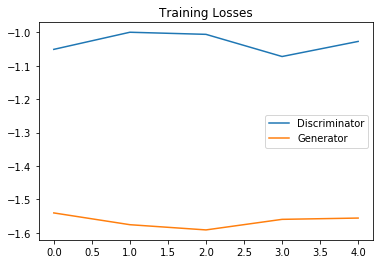

In [34]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

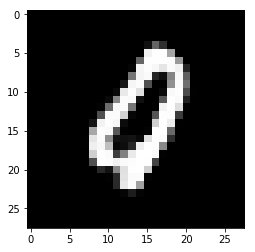

In [36]:
plt.imshow(np.reshape(samples[4][0][0],(28,28)), cmap='Greys_r')

In [37]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(),samples[epoch][0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(np.reshape(img, (28,28)), cmap='Greys_r')
    
    return fig, axes

In [38]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

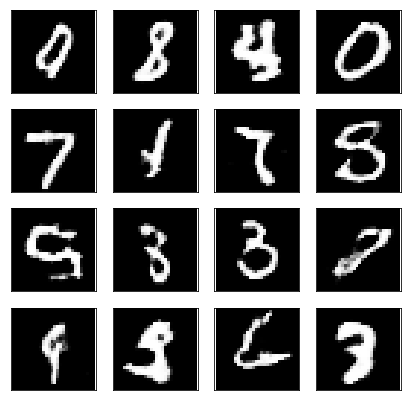

In [39]:
_ = view_samples(-1, samples)

In [40]:
samples[::10][0]

(array([[[[-0.97375876],
          [-0.9982893 ],
          [-0.9977517 ],
          ...,
          [-0.9984916 ],
          [-0.9975334 ],
          [-0.9847211 ]],
 
         [[-0.9984214 ],
          [-0.99994695],
          [-0.9999953 ],
          ...,
          [-0.99997765],
          [-0.99998975],
          [-0.999601  ]],
 
         [[-0.99904877],
          [-0.9998704 ],
          [-0.99999726],
          ...,
          [-0.99996525],
          [-0.9999996 ],
          [-0.99994314]],
 
         ...,
 
         [[-0.98988396],
          [-0.999597  ],
          [-0.9999486 ],
          ...,
          [-0.9997948 ],
          [-0.9968366 ],
          [-0.96970844]],
 
         [[-0.991396  ],
          [-0.9998333 ],
          [-0.9999095 ],
          ...,
          [-0.99776095],
          [-0.9880023 ],
          [-0.98766583]],
 
         [[-0.9611167 ],
          [-0.99731755],
          [-0.99525136],
          ...,
          [-0.9984942 ],
          [-0.9936659 ],
    

IndexError: index 4 is out of bounds for axis 0 with size 4

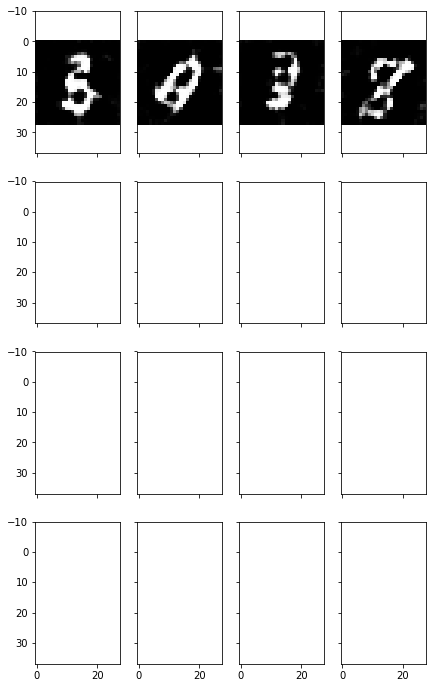

In [42]:
rows, cols = 4, 4
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for ax_row, sample in zip(axes, samples[::int(len(samples)/rows)]):
    for ax, img  in zip(ax_row, sample[::int(len(samples)/cols)]):
        ax_row[0].imshow(np.reshape(img[0],(28,28)), cmap='Greys_r')
        ax_row[1].imshow(np.reshape(img[1],(28,28)), cmap='Greys_r')
        ax_row[2].imshow(np.reshape(img[2],(28,28)), cmap='Greys_r')
        ax_row[3].imshow(np.reshape(img[3],(28,28)), cmap='Greys_r')
        ax_row[4].imshow(np.reshape(img[4],(28,28)), cmap='Greys_r')
        ax_row[5].imshow(np.reshape(img[5],(28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<matplotlib.figure.Figure at 0x7fcc324fa198>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc300c7f60>,
       dtype=object))

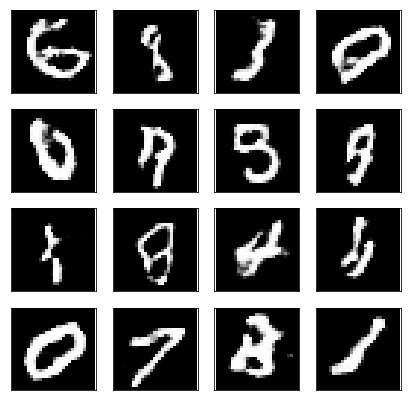

In [44]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    sample_c = np.zeros(shape=[16, n_cat])
    sample_c[:, 5] = 1
    gen_samples = sess.run(generator(input_z, sample_c, input_size, reuse=True),feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])